<center>
    <img src="../assets/BINGO_LOGO-cor.png" width="20%" >
</center>
<center><h1> Radiotools: Simple Radioastronomy </h1></center>

## Inicialização

In [1]:
# Mostra todos os resultados da célula, não apenas o último
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
InteractiveShell.ast_node_interactivity = "all"
#--------------------
# Utils
import sys
import os
import numpy as np
import pandas as pd
from datetime import datetime
from pytz import timezone
import astropy.coordinates as coord
from astropy import units as u
# Local imports
sys.path.insert(0, os.path.abspath('../src/'))
fuso = timezone("America/Recife")

In [2]:
from radiotools import Uirapuru  #Objeto Instrument pré-definido.
from radiotools import CallistoSpectrometer  #Classe Backend implementada.
from radiotools import Observations  #Classe para planejamento e visualização de observações.
import radiotools.observations as obs  #Funções de módulo auxiliares.

## Instrumento

In [3]:
Uirapuru = Uirapuru.set_observatory()
Uirapuru.name
Uirapuru.lat, Uirapuru.lon
Uirapuru.Alt, Uirapuru.Az
Uirapuru.fwhm
if not Uirapuru.backend:
    print("backend ainda não definido")
if not Uirapuru.observatory:
    print("objeto observatório ainda não definido")
else:
    Uirapuru.observatory

'Uirapuru'

(<Quantity -7.211637 deg>, <Quantity -35.908138 deg>)

(84, 0)

15

backend ainda não definido


<GeographicPosition WGS84 latitude -7.2116 N longitude -35.9081 E elevation 553.0 m>

## Backend

In [4]:
# Parâmetros de Inicialização do objeto backend.
path = "../data/external/callisto/"
name_device = "BINGO"
# Inicializando objeto e fazendo chaining para ler os arquivos disponíveis no disco e fazer a 
# calibração da conversão de Volt para dB caso exista informação suficiente.
backend = CallistoSpectrometer(name=name_device, path=path)._get_files_timestamps()._calibrate_slope()

Could not find suitable files to calibrate. Nominal value is set.


In [5]:
Uirapuru.backend = backend

## Observations

Vamos informar os dados em horário local. O pacote trabalha internamente em UTC mas permite visualizar os rótulos tanto em horário local como em utc com o uso de uma flag. Qualquer entrada de tempo reconhecida por `pd.to_datetime` pode ser utilizada.

In [7]:
begin = Uirapuru.timezone.localize(pd.to_datetime("2021-09-01 7:10:00"))
end = Uirapuru.timezone.localize(pd.to_datetime("2021-09-01 17:25:00"))
duration = (end-begin).total_seconds()
duration_obs = duration*u.s + 900*u.s

trial_run = Observations(t_start = begin,
                         duration = duration_obs, 
                         instrument = Uirapuru)

A partir da informação dos tempos de observação queremos construir um vetor de tempo a intervalos especificados e nestes tempos queremos determinar a posição do apontamento do radiotelescópio, dadas as suas coordenadas horizontais fixas. Estas operações podem ser concatenadas. Na linha abaixo esta a chamada a ao método `make_timevector` com seus valores default, equivalente a chamar `make_timevector()`.

A opção `duration` passada à função substitui a duração definida na propriedade do objeto. `delta` é uma quantidade de tempo que corresponde ao intervalo entre cada posição sucessiva. A opção `inplace` retorna `self`, de forma que pode ser concatenada com outros métodos do objeto. Se `inplace = False` o método retorna um vetor de tempo no formato de escala temporal do skyfield.

### Tempos e Apontamentos

In [ ]:
trial_run = trial_run.make_timevector(duration = None, delta = 5 * u.min, inplace = True)
trial_run.timevector
trial_run.make_timevector(duration = None, delta = 6 * u.h, inplace = False)

Para a determinação das posições dos apontamentos do radiotelescópio em coordenadas equatoriais, é necessário chamar o método `make_pointings`, que pode ser concatenado com a chamada anterior de `make_timevector()` ou pode utilizar os valores da propriedade `timevector` do objeto.

É possível também passar o vetor de tempo diretamente a `make_timevector()`.

In [23]:
trial_run.make_pointings(timevector=None)
trial_run.pointings[0:10]

<SkyCoord (ICRS): (ra, dec) in deg
    [( 97.11127034, -1.19915775), ( 98.36468346, -1.19653804),
     ( 99.61809557, -1.19392555), (100.87150635, -1.19132154),
     (102.12491612, -1.18872725), (103.37832458, -1.18614392),
     (104.63173206, -1.18357279), (105.88513824, -1.18101509),
     (107.13854331, -1.17847204), (108.39194743, -1.17594486)]>

A função `make_pointings()` produz um objeto astropy `SkyCoord` que pode ser utilizado eficientemente em outras opperações, mas é frequente a necessidade de termos uma informação de tempos e posições de forma legível para humanos e neste caso o `dataframe` é mais adequado. A função conveniência `make_pointings_df()` permite recuperar estas informações e ainda permite alterar o intervalo de tempo. O parâmetro `interval` é uma string temporal para pandas `resample` e `utc = False` retorna o tempo local.

In [24]:
# Downsampling
trial_run.make_pointings_df(interval = "3h", utc = False)

,RA,DEC,NAME
2021-09-01 07:10:00.000005-03:00,97.111270,-1.199158,Uirapuru
2021-09-01 10:10:00.000005-03:00,142.233490,-1.117868,Uirapuru
2021-09-01 13:10:00.000005-03:00,187.354890,-1.091789,Uirapuru
2021-09-01 16:10:00.000005-03:00,232.476425,-1.136276,Uirapuru


É possível visualizar o apontamento das observações, levando-se em conta o fwhm do feixo do instrumento.
- `timestamps = True` implica em mostrar o horário das observações no gráfico.
- `circles = True` mostra o feixe como um círculo cujo diâmetro é o fwhm.
- `utc = False` imprime as timestamps no horário local.
- `interval = "1h"` determina a periodicidade imposta no dataframe de pointings. É uma string válida para `asfreq` do  pandas e algum cuidado deve ser tomado se a periodicidade do timevector for próxima, pois o método usa `bfill`.
- `ra_lim`e `dec_lim` serão apresentadas abaixo, indicam o range para as coordendadas equatoriais indicadas como unidades de ângulo do `astropy`. Como a função calcula o bounding box do world coordinate axes é necessário que as duas sejam fornecidas simultaneamente. Não é possível indicar apenas os limites RA ou DEC.
- `h_offset` e `v_offset` posicionam o rótulo de texto timestamp.
- `legend_offset` determina o posicionamento vertical da legenda.
- `galactic = True` coloca o grid do sistema de coordenadas galácticas no gráfico.
- `wcs` é uma projeção possível para o pacote wcs. Alguns casos podem apresentar problemas devido ao bounding box. Os usos mais comuns são `CAR` que denota `plate-carré`, `MOL` que denota `mollweide` e `TAN`que denota gnomônica.

Note que o eixo de ascenção reta segue a convenção celeste e é indicado em horas, centrado no centro do período de observação e com as horas aumentando da direita para a esquerda.

A função não produz resultado se o período de observação foi superior a 24h porque esta visualizaçlão deixa de ser útil neste caso.

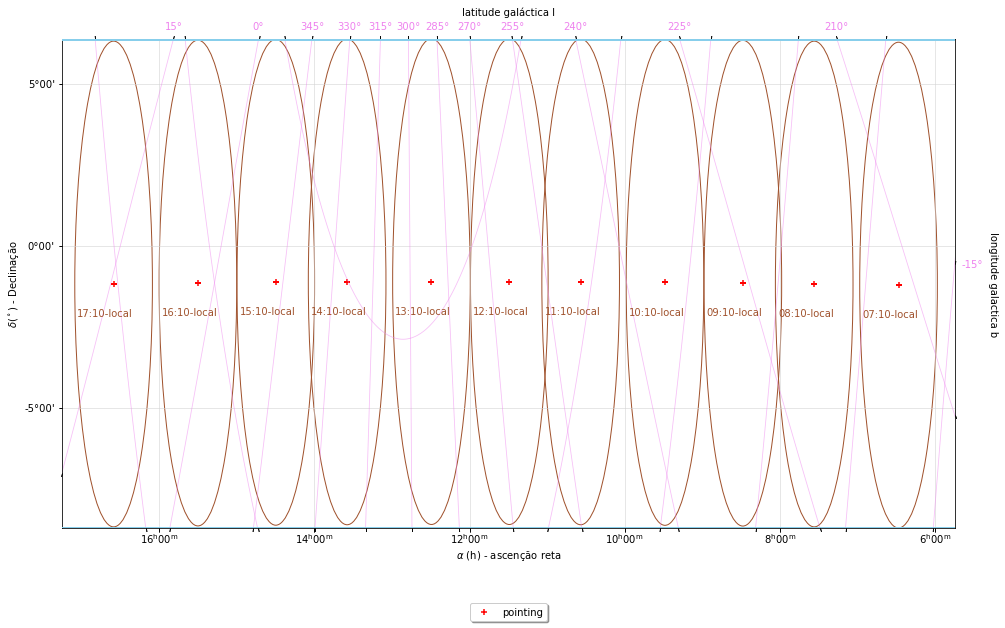

In [30]:
trial_run.plot_pointings(timestamps = True, circles = True, utc = False, interval = "1h", ra_lim = None, 
               dec_lim = None, h_offset = 7, v_offset = -1,legend_offset = -.2, galactic = True,
               wcs = "CAR");

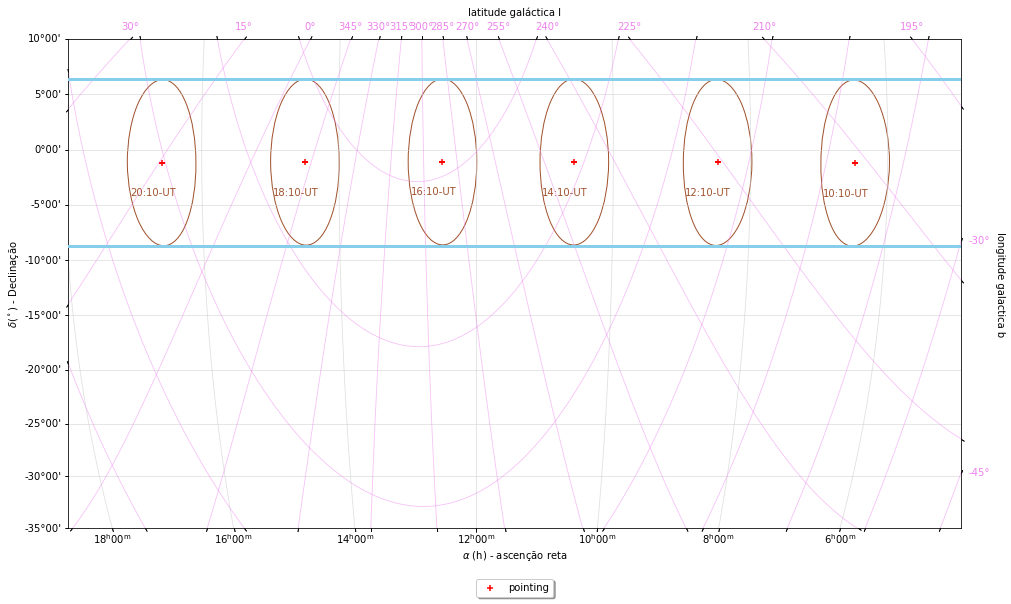

In [35]:
trial_run.plot_pointings(timestamps = True,
                         circles = True,
                         utc = True,
                         interval = "2h",
                         v_offset = -3,
                         ra_lim = [18*u.hourangle, 4*u.hourangle],
                         dec_lim = [-35*u.deg,10*u.deg],
                         galactic = True,
                         wcs = "MOL",
                         legend_offset=-0.15);

### Objetos Locais

Uma vez determinadas as posições das observações, é possível saber quais objetos estão sendo observados, quer sejam objetos de interesse para as medições quer sejam objetos que atrapalhem as medições.


O objeto mantém informações acerca de objetos locais de interesse identificados com a propriedade `local_objects`.

In [36]:
trial_run.local_objects

['sun',
 'moon',
 'mercury barycenter',
 'venus barycenter',
 'mars barycenter',
 'jupiter barycenter',
 'saturn barycenter']

Objetos cujas coordenadas equatoriais variam (objetos próximos) tem suas informações obtidas usando métodos `get`. A configuração padrão do método acessa a propriedade `local_objects` mas qualquer coleção iterável de objetos válidos do arquivo de efemérides pode ser passada diretamente ao método com o parâmetro `objects`.

O arquivo de ephemerides pode ser acessado para saber quais objetos são válidos.

In [37]:
print(trial_run._eph)

SPICE kernel file 'de440s.bsp' has 14 segments
  JD 2396752.50 - JD 2506352.50  (1849-12-25 through 2150-01-21)
      0 -> 1    SOLAR SYSTEM BARYCENTER -> MERCURY BARYCENTER
      0 -> 2    SOLAR SYSTEM BARYCENTER -> VENUS BARYCENTER
      0 -> 3    SOLAR SYSTEM BARYCENTER -> EARTH BARYCENTER
      0 -> 4    SOLAR SYSTEM BARYCENTER -> MARS BARYCENTER
      0 -> 5    SOLAR SYSTEM BARYCENTER -> JUPITER BARYCENTER
      0 -> 6    SOLAR SYSTEM BARYCENTER -> SATURN BARYCENTER
      0 -> 7    SOLAR SYSTEM BARYCENTER -> URANUS BARYCENTER
      0 -> 8    SOLAR SYSTEM BARYCENTER -> NEPTUNE BARYCENTER
      0 -> 9    SOLAR SYSTEM BARYCENTER -> PLUTO BARYCENTER
      0 -> 10   SOLAR SYSTEM BARYCENTER -> SUN
      3 -> 301  EARTH BARYCENTER -> MOON
      3 -> 399  EARTH BARYCENTER -> EARTH
      1 -> 199  MERCURY BARYCENTER -> MERCURY
      2 -> 299  VENUS BARYCENTER -> VENUS


A opção `CONE = False` não efetua a filtragem do ângulo de apontamento com o objeto celeste. Com `CONE = True` apenas objetos no feixe são apresentados. Esta função pode retornar um dataframe `empty`.

In [40]:
df_local_objects = trial_run.get_local_objects(objects = None, CONE = False)
df_local_objects.head(3)
df_local_objects = trial_run.get_local_objects(objects = None, CONE = True)
df_local_objects.head(3)

,TIME,RA,DEC,ANGLE,DISTANCE,NAME
0,2.459459e+06,130.439924,19.097284,38.503607,1.356338e+09,saturn
1,2.459459e+06,130.439724,19.097337,37.462580,1.356343e+09,saturn
2,2.459459e+06,130.439525,19.097390,36.433253,1.356347e+09,saturn


,TIME,RA,DEC,ANGLE,DISTANCE,NAME


### Satélites GNSS

Satélites GNSS são poderosas fontes de interferência e estão muito presentes no feixe. São consideradas apenas as constelações de satélites que sabidamente emitem da banda próxima a 1GHz, GPS, Galileo, Glonass, Beidou. As informações de posições são obtidas baixando informações no formato TLE diretamente do site celestrak. É possível passar a informação de TLE diretamente para a função e o parâmetro CONE funciona de modo similar.

In [41]:
obs.TLE_urls

['https://celestrak.com/NORAD/elements/gnss.txt',
 'https://celestrak.com/NORAD/elements/gps-ops.txt',
 'https://celestrak.com/NORAD/elements/glo-ops.txt',
 'https://celestrak.com/NORAD/elements/galileo.txt',
 'https://celestrak.com/NORAD/elements/beidou.txt',
 'https://celestrak.com/NORAD/elements/sbas.txt']

In [42]:
df_satellites = trial_run.get_satellites(TLE = None, CONE = True)
df_satellites.head(3)

,TIME,RA,DEC,ANGLE,DISTANCE,NAME
56,2.459459e+06,163.946500,3.141988,5.406090,20174.139263,GPS BIIR-11 (PRN 19)
57,2.459459e+06,165.401137,0.391055,3.488965,20147.237734,GPS BIIR-11 (PRN 19)
58,2.459459e+06,166.856444,-2.361434,3.213581,20131.675986,GPS BIIR-11 (PRN 19)


### Objetos Distantes

#### Catálogo NVSS

Intensas fontes de rádio, pulsares e fontes do catálogo NVSS tem coordenadas equatoriais fixas e podem ser acessadas com funções do módulo (`load`) ou é possível solicitar o download (`fetch`)

A função `fetch_nvss_catalogs` aceita como parâmetros `filename`, dois filtros utilizados na consulta vizier (`DEC_FILTER = "<10 && >-30"`, `S1400_mjy = ">100"`) e uma string para `query()` no dataframe resposta (`query = "DEC >-20 & DEC < 10 & S1400>100"`). Todos os parâmetros são opcionais.

A função `load_nvss_catalog` aceita como parâmetro o `filename` e chama a função `fetch` se não conseguir encontrar o arquivo desejado localmente.

Ambas funções retornam dataframes.

In [44]:
obs.fetch_nvss_catalogs(filename = "../data/auxiliary/nvss_radiosources.csv", 
                        DEC_FILTER = "<10 && >-30", 
                        S1400_mjy = ">100", 
                        query = "DEC >-20 & DEC < 10 & S1400>100").head(4)

df_nvss = obs.load_nvss_catalog(filename = "../data/auxiliary/nvss_radiosources.csv")

arquivo salvo em disco: ../data/auxiliary/nvss_radiosources.csv


,NAME,RA,DEC,S1400
0,000000-040242,0.000667,-4.045083,106.8
1,000000+004100,0.001625,0.683333,149.5
2,000001-002209,0.006875,-0.369361,212.5
3,000002+095706,0.011958,9.951833,301.4


#### Catálogo de Pulsares

O catálogo de pulsares pode ser acessado e carregado. `query` é uma string para realizar `query` no dataframe.

In [47]:
obs.fetch_pulsar_catalogs(filename = "../data/auxiliary/pulsares.csv", 
                          query = "DEC >-20 & DEC < 10 & S1400>10").head(3)
df_pulsares = obs.load_pulsares()
df_pulsares.head(3)

arquivo salvo em disco: ../data/auxiliary/pulsares.csv


,NAME,RA,DEC,DIST,P0,DM,S1400
32,J0034-0721,8.53696,-7.36484,1.03,0.942951,10.92200,11.0
359,J0953+0755,148.28879,7.92660,0.26,0.253065,2.96927,84.0
1060,J1645-0317,251.25851,-3.29953,2.61,0.387690,35.75550,21.0


,NAME,RA,DEC,DIST,P0,DM,S1400
0,J0034-0721,8.53696,-7.36484,1.03,0.942951,10.92200,11.0
1,J0953+0755,148.28879,7.92660,0.26,0.253065,2.96927,84.0
2,J1645-0317,251.25851,-3.29953,2.61,0.387690,35.75550,21.0


#### Radiofontes com identificadores em SIMBAD

O módulo mantém uma lista das fontes de rádio mais intensas

In [48]:
obs.RADIOSOURCES

['Cassiopeia A',
 'Centaurus A',
 'Cygnus A',
 'Fornax A',
 'Hercules A',
 'Hydra A',
 'Pictor A',
 'Puppis A',
 'Sagittarius A*',
 'Taurus A',
 'Virgo A']

In [52]:
_ = obs.fetch_radiosources()
df_radio = obs.load_radiosources()
df_radio.head(5)

arquivo salvo em disco: ../data/auxiliary/radiosources.csv


,MAIN_ID,RA,DEC,NAME
0,NAME Cas A,350.850000,58.815000,Cassiopeia A
1,NAME Centaurus A,201.365062,-43.019112,Centaurus A
2,NAME Cyg A,299.868152,40.733916,Cygnus A
3,NGC 1316,50.674121,-37.208200,Fornax A
4,NAME Hercules A,252.783433,4.993031,Hercules A


Se quisermos uma outra fonte adicional, podemos acessar o mesmo catálogo e usar a função com parâmetros.

In [54]:
obs.fetch_radiosources(filename = "../data/auxiliary/new_sources.csv", radiosources = ["3C273", "M12"])
df_newradio = obs.load_radiosources(filename = "../data/auxiliary/new_sources.csv")

arquivo salvo em disco: ../data/auxiliary/new_sources.csv


,MAIN_ID,RA,DEC,NAME
0,3C 273,187.277915,2.052388,3C273
1,M 12,251.809083,-1.948528,M12


## Consolidando visões do céu.

Todos os objetos podem ser colecionados com um método de conveniência.

In [57]:
df_all = trial_run.get_all_beam()
df_all.describe()

,TIME,RA,DEC,ANGLE,DISTANCE
count,1.050000e+02,105.000000,105.000000,105.000000,1.050000e+02
mean,2.459459e+06,200.828820,-0.365142,5.355065,1.204884e+22
std,1.302684e-01,47.080091,3.974379,1.639555,1.512590e+22
min,2.459459e+06,96.791917,-7.856591,1.131451,1.906373e+04
25%,2.459459e+06,166.856444,-3.447876,4.164137,2.013150e+04
50%,2.459459e+06,210.749032,-0.242614,5.553651,2.325928e+04
75%,2.459459e+06,251.258510,2.957320,6.744866,3.085678e+22
max,2.459459e+06,260.143625,6.147459,7.470376,3.085678e+22


### Visão equatorial

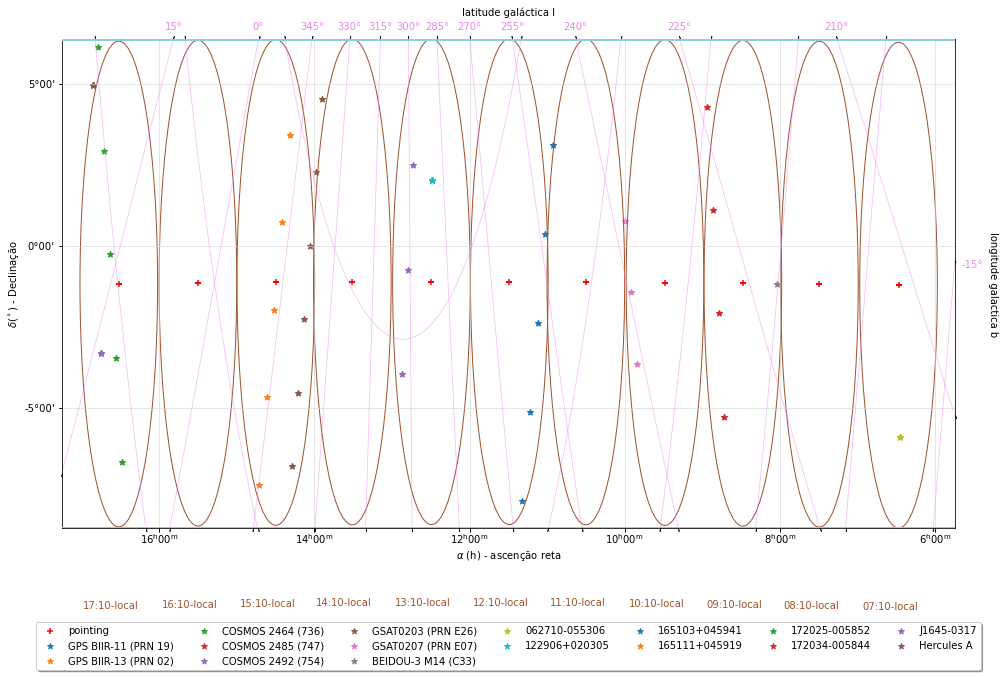

In [63]:
trial_run = trial_run.make_timevector(delta = 1*u.min).make_pointings()
ax = trial_run.plot_pointings();
obs.plot_df(df_all, group="NAME", ax = ax, marker = "*");

### Visão Horizontal

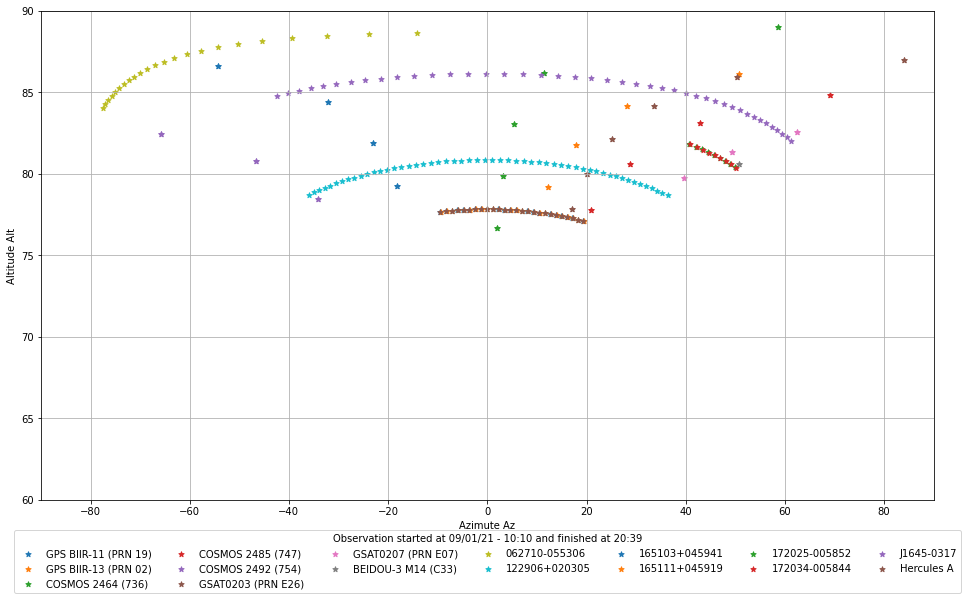

In [87]:
trial_run = trial_run.make_timevector(delta = 1*u.min).make_pointings()
ax = trial_run.plot_sky(markersize = 30)
#trial_run.plot_galaxy_altaz(ax = ax, size = 120, utc = False);

### Onde foi a galáxia?

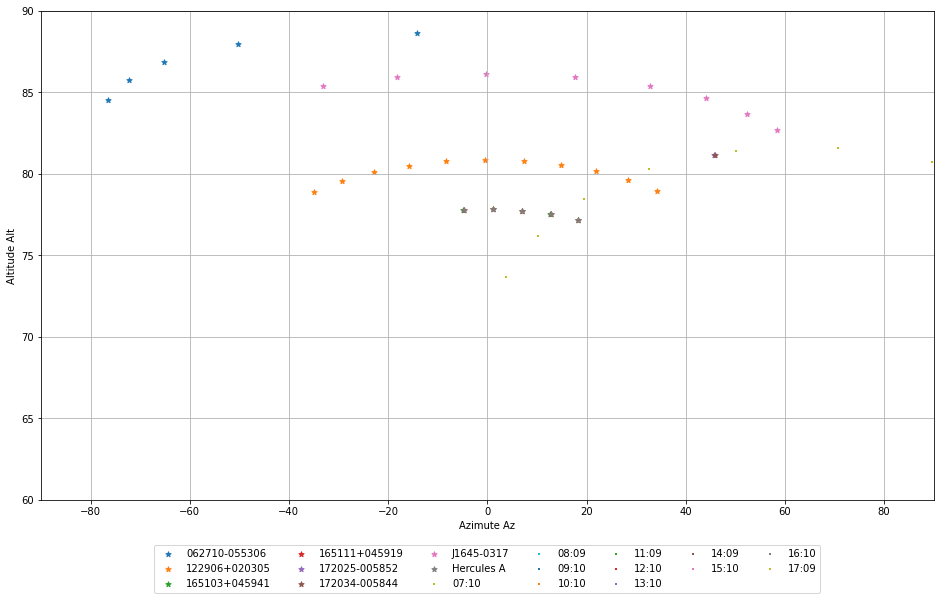

In [89]:
objects = df_all[df_all.TYPE != "GNSS"]
objects_sky = trial_run.get_altaz_from_radec(objects)
objects_sky["TIME"] = pd.to_datetime(objects_sky["TIME"].values, unit = "D", origin="julian")
ax = trial_run.plot_sky(objects = objects_sky, markersize = 30);
trial_run.plot_galaxy_altaz(ax = ax, size = 120, utc = False);

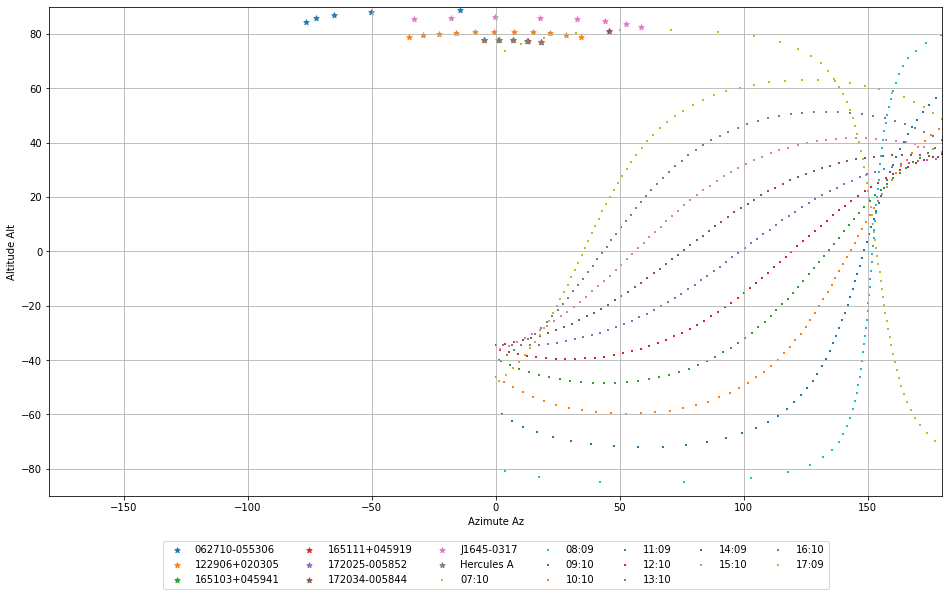

In [91]:
ax = trial_run.plot_sky(objects = objects_sky, markersize = 30);
trial_run.plot_galaxy_altaz(ax = ax, size = 120, utc = False);
ax.set_xlim([-180,180]);
ax.set_ylim([-90,90]);

## Carregando dados do receptor

Could not find suitable files to calibrate. Nominal value is set.
Could not find suitable file to calibrate. Using constante background as 170 digits. Provide Dcold dataframe as argument of the function manually instead.


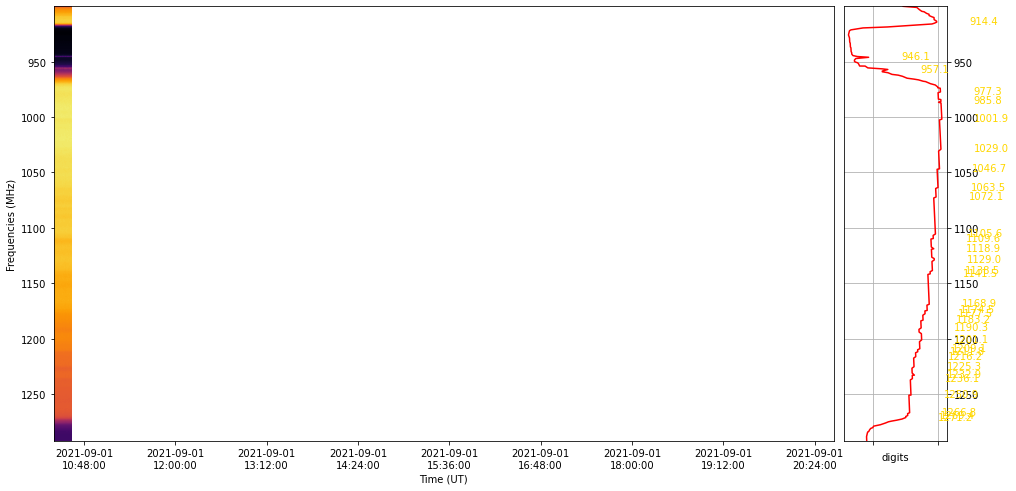

In [94]:
df_data = trial_run.load_observation()
trial_run.plot_waterfall(df = df_data);

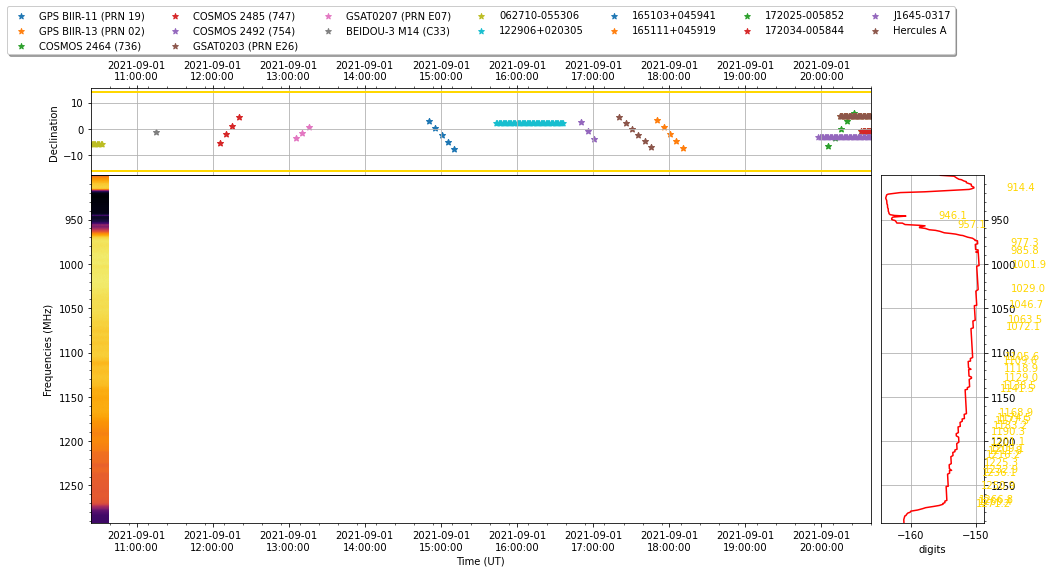

In [95]:
df_sky = trial_run.get_all_beam()
df_sky["TIME"] = pd.to_datetime(df_sky.TIME.values, unit = "D", origin = "julian")
trial_run.plot_timeseries(df_data, df_sky);

Could not find suitable files to calibrate. Nominal value is set.
Could not find suitable file to calibrate. Using constante background as 170 digits. Provide Dcold dataframe as argument of the function manually instead.


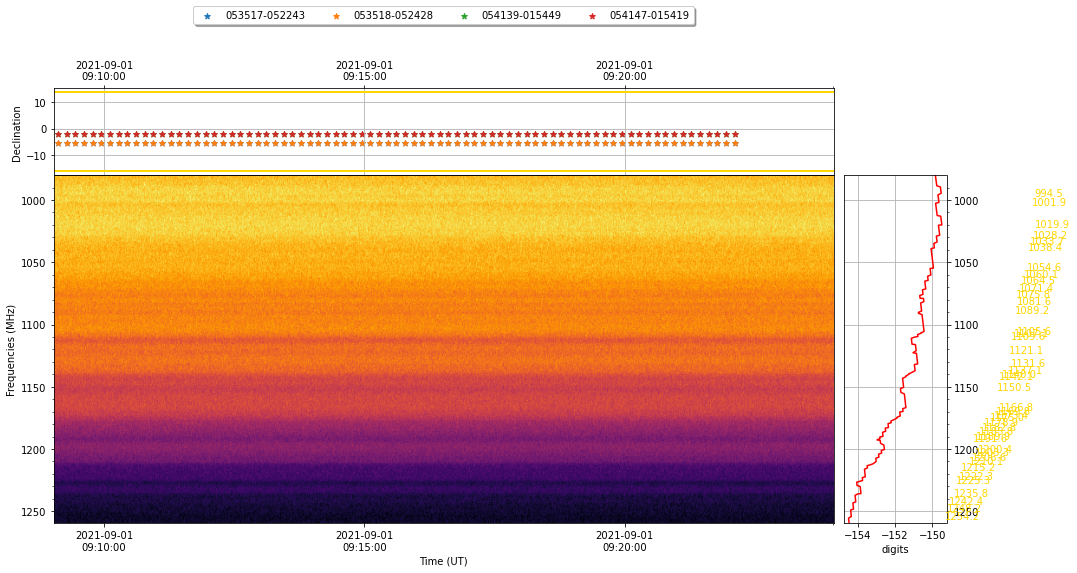

In [110]:
begin = Uirapuru.timezone.localize(pd.to_datetime("2021-09-01 06:05:00"))
duration_obs = 1000*u.s 
trial_run = Observations(t_start = begin, 
                             duration = duration_obs, 
                             instrument = Uirapuru).make_timevector(delta = 10*u.s).make_pointings()
df_data = trial_run.load_observation()
df_data_filt = trial_run.filter_data(df_data, freqs = [980, 1260], sampling = "1S")
df_sky = trial_run.get_all_beam()
df_sky["TIME"] = pd.to_datetime(df_sky.TIME.values, unit = "D", origin = "julian")
trial_run.plot_timeseries(df_data_filt, df_sky);